<a href="https://colab.research.google.com/github/goralex02/Data_Processing_and_Machine_Learning/blob/main/Text_classification_Gorbuntsov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Сравнение алгоритмов классификации текстов**

Горбунцов Александр
aagorbuntsov@edu.hse.ru

Ссылка на этот ноутбук в google colab: https://colab.research.google.com/drive/1lGhPjHpC9irgaLIaIhkxF77PlWk8C7EC?usp=sharing

В .csv файле представлена совокупность данных: заголовок новости, тема новости, текст новости. Все слова в тексте лемматизированы, а сами тексты очищены от стоп-слов.

Вам необходимо выбрать и сравнить между собой не менее трех различных алгоритмов классификации текстов, проанализировать полученные результаты и сделать обоснованные выводы о применимости выбранных методов и качестве решения задачи.

Я планирую протестировать следующие алгоритмы:

1. Логистическая регрессия с Bag of Words — линейный алгоритм классификации, который предсказывает вероятность принадлежности объекта к тому или иному классу. Для текстов часто используется представление Bag of Words, где тексты преобразуются в векторы на основе частоты встречаемости слов без учета их порядка.

2. Случайный лес с TF-IDF — ансамблевый метод, основанный на построении нескольких решающих деревьев и их комбинации для повышения точности классификации. TF-IDF (term frequency-inverse document frequency) — метод взвешивания слов в зависимости от их важности в документе, уменьшающий вес часто встречающихся слов, таких как предлоги, союзы, и акцентирующий внимание на уникальных терминах.

3. Классификатор на основе модели RuBERT-tiny2 с AutoModelForSequenceClassification -- RuBERT-tiny2 это облегченная версия BERT, специально обученная для русского языка. Метод AutoModelForSequenceClassification из библиотеки Transformers используется для предобученных моделей, адаптированных к задачам классификации. В этом подходе текст токенизируется с помощью предобученного токенизатора модели RuBERT-tiny2, затем передается в модель для классификации на основе последовательностей.

4. Сверточная нейронная сеть с токенизатором RuBERT-tiny2 -- традиционно такие нейронные сети применяются для обработки изображений, но также могут быть адаптированы для обработки текста, захватывая важные локальные паттерны. Использую предобученные эмбеддинги RuBERT-tiny2 — облегченную модель BERT для русского языка, которая создает качественные представления слов на основе их контекста.

5. Модель Zero-Shot -- подход, который позволяет модели классифицировать тексты по темам, на которых она не была обучена напрямую. В данном случае используется модель типа MiniLMv2-L6, которая способна предсказывать классы с помощью сопоставления гипотез на естественном языке (например, "Этот текст о {}").


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
data = 'drive/MyDrive/Colab_Notebooks/data/articles_lemmatized_no_SW.csv'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(data)

## **Разведка и предобработка данных**

Для начала я хочу узнать с чем вообще имею дело.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56500 entries, 0 to 56499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56500 non-null  int64 
 1   headline    56500 non-null  object
 2   body        56499 non-null  object
 3   topic       56500 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [ ]:
df.head(10)

,Unnamed: 0,headline,body,topic
0,4069,Теперь подарки можно выбрать на сайте при помо...,поиск подарок любой праздник гораздо просто бл...,IT
1,1666,Тренды розничной торговли 2016,платформа соцсеть продолжать служить шопинг-пл...,IT
2,1802,Порталы сравнения цен вынуждают мелких ритейле...,последний время активно расти конкуренция обла...,IT
3,3784,9 беспроигрышных подарков для мужчины,каждый накануне февраль возникать сложный вопр...,IT
4,2186,Китайские производители сокращают свой бизнес ...,прекращать поставка новый автомобиль дилер рос...,Авто
5,6624,Глава Подмосковья дал старт строительству ново...,дорожный сооружение появляться пересечение вол...,Авто
6,6625,В Крыму продолжается переход на российские гос...,легально передвигаться полуостров украинский н...,Авто
7,38807,Страховые компании назвали марки самых угоняем...,опасаться злоумышленник следовать владелец дор...,Авто
8,9418,На 14-м Пекинском международном автосалоне пре...,большой интерес публика привлекать китайский и...,Авто
9,9352,Названы лучшие автомобили года в России,москва состояться церемония вручение ежегодный...,Авто


In [ ]:
# посчитаем количество уникальных тем
unique_topics = df['topic'].unique()
print (f'Число уникальных тем: {len(unique_topics)}')

Число уникальных тем: 37


In [ ]:
# Проверка на дубликаты в столбце 'body'
duplicates = df[df['body'].duplicated(keep=False)]  # keep=False возвращает все дубликаты

# Вывод информации о дубликатах
if duplicates.empty:
    print("Дубликатов в столбце 'body' нет.")
else:
    print("Дубликаты в столбце 'body':")
    print(duplicates)

Дубликаты в столбце 'body':
       Unnamed: 0                                         headline  \
51415       14989  УЕФА готов применить санкции по отношению к РФС   
51436       14971  УЕФА готов применить санкции по отношению к РФС   

                                                    body    topic  
51415  футбольный власть расследовать поведение росси...  ЧЕ 2016  
51436  футбольный власть расследовать поведение росси...  ЧЕ 2016  


In [ ]:
# удалим дубликаты
df.drop_duplicates(subset=['body'], keep='first', inplace=True)
# Проверка на дубликаты в столбце 'body'
duplicates = df[df['body'].duplicated(keep=False)]  # keep=False возвращает все дубликаты

# Вывод информации о дубликатах
if duplicates.empty:
    print("Дубликатов в столбце 'body' нет.")
else:
    print("Дубликаты в столбце 'body':")
    print(duplicates)

Дубликатов в столбце 'body' нет.


In [ ]:
# смотрим на пропущенные значения
df_empty_body = df[df['body'].isnull()]

# Выводим элементы DataFrame с пустым столбцом 'body'
print(df_empty_body)

     Unnamed: 0                      headline body topic
107        3926  Приключения LADA XRAY в Сочи  NaN  Авто


In [ ]:
# Удаление записей с NULL в столбце body
df = df[df['body'].notna()]

df_empty_body = df[df['body'].isnull()]

# Выводим элементы DataFrame с пустым столбцом 'body'
print(df_empty_body)

Empty DataFrame
Columns: [Unnamed: 0, headline, body, topic]
Index: []


In [ ]:
# смотрим на пропущенные значения в теме
df_empty_topic = df[df['topic'].isnull()]
print(df_empty_topic)

Empty DataFrame
Columns: [Unnamed: 0, headline, body, topic]
Index: []


In [ ]:
# Подсчет числа символов в каждом тексте
df['body'] = df['body'].astype(str)
df['char_count'] = df['body'].apply(len)

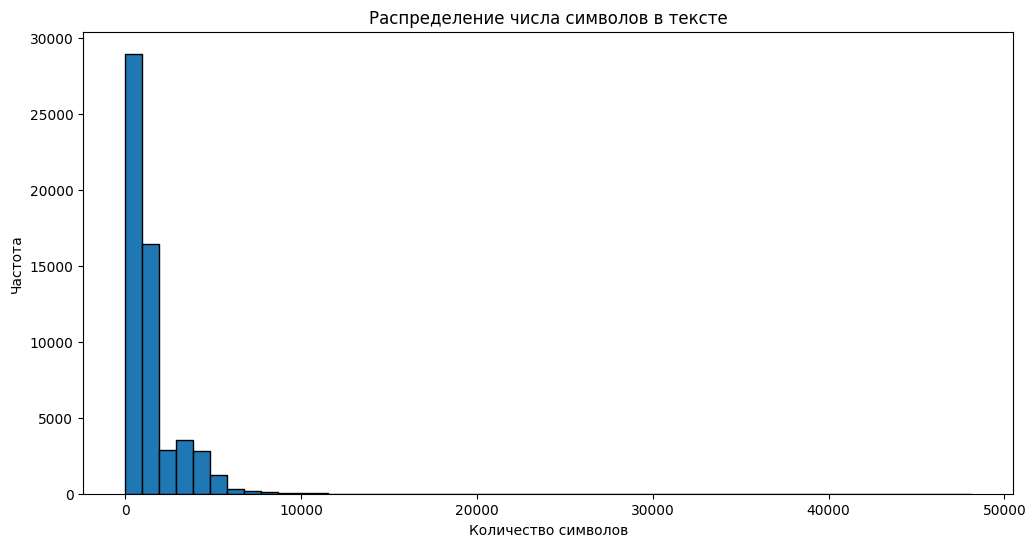

In [ ]:
# Создание гистограммы
plt.figure(figsize=(12, 6))  # Установка размера фигуры
plt.hist(df['char_count'], bins=50, edgecolor='black')  # Создание гистограммы с 35 столбцами
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.title('Распределение числа символов в тексте')
plt.show()

In [ ]:
# Вычисление 1%-го процентиля длины текста
percentile_1 = df['char_count'].quantile(0.01)
percentile_90 = df['char_count'].quantile(0.90)

# Фильтрация 1% самых коротких и 1% самых длинных текстов
shortest_texts = df[df['char_count'] <= percentile_1]
longest_texts = df[df['char_count'] >= percentile_90]

print(f"1% самых коротких текстов имеет длину менее чем {percentile_1} символов.")
print(f"10% самых длинных текстов имеет длину более чем {percentile_90} символов.")

1% самых коротких текстов имеет длину менее чем 372.0 символов.
10% самых длинных текстов имеет длину более чем 3604.0 символов.


In [ ]:
# Сортируем DataFrame по длине текста
df_sorted = df.sort_values(by='char_count').head(10)

# Выводим 10 самых коротких текстов и их длину
shortest_texts = df_sorted[['body', 'char_count', 'topic']]

print(shortest_texts)

                                                    body  char_count  \
2079                                           тест тест           9   
44627        турнир франция наступать пора решающий матч          43   
40968    расписание календарь летний игра рио-де-жанейро          47   
15697  любопытный владелец дрон снимать видео изнутри...         106   
18572  результат пострадать человек человек пострадат...         131   
14239  информация причина взрыв раненый разрушение по...         139   
34825  республиканец набирать голос необходимый канди...         144   
2367   декабрь исполняться знаменитый мультипликатор ...         145   
28401  движение поезд пока останавливать метро брюссе...         152   
18199  получать различный травма берлин территория ро...         162   

                   topic  
2079   Гаджеты & Телеком  
44627              Спорт  
40968           РИО-2016  
15697                Мир  
18572                Мир  
14239                Мир  
34825           По

In [ ]:
# Сортируем DataFrame по длине текста для длинных текстов
df_sorted_long = df.sort_values(by='char_count', ascending=False).head(10)

# Выводим 10 самых длинных текстов и их длину
longest_texts = df_sorted_long[['body', 'char_count', 'topic']]

print("\n10 самых длинных текстов:")
print(longest_texts)


10 самых длинных текстов:
                                                    body  char_count  \
1555   сентябрь рф проходить выборы депутат госдума с...       48095   
24958  вылет сочи разбиваться тот- минобороны россия ...       34493   
38959  четыре час президент отвечать вопрос российски...       33213   
35800  тринадцатый послание федеральный собрание глав...       31342   
11912  председатель комитет совет федерация междунаро...       25563   
37939  дискредитация власть накануне выборы главный ц...       23836   
38485  спикер совет федерация валентина матвиенко уве...       20008   
34202  москва завершаться прямой линия президент росс...       19592   
35852  президент фонд общественный мнение александр о...       19491   
56221  руководитель служба защита право потребитель ф...       18769   

             topic  
1555   Выборы-2016  
24958     Общество  
38959     Политика  
35800     Политика  
11912          Мир  
37939     Политика  
38485     Политика  
34202     По

90% текстов имеет длину менее чем 3604 символа -- в русском языке это приблизительно 612.68 слов и 1.45 страниц. Обрежем длинные тексты по данному значению, и удалим бессмысленный текст с содержанием "тест тест".

In [ ]:
# Обрезка длины body до 6180 символов
df['body'] = df['body'].str[:3604]

# Фильтруем DataFrame, оставляя только строки с длиной текста >= 10
df = df[df['char_count'] >= 10]

<ipython-input-17-4ece5650eb3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['body'] = df['body'].astype(str)


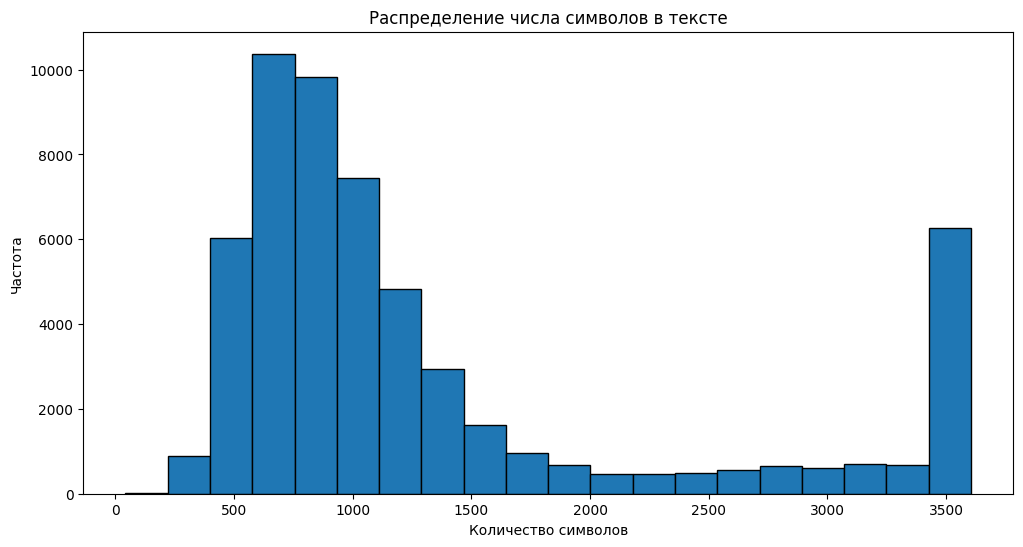

In [ ]:
# Подсчет числа символов в каждом тексте
df['body'] = df['body'].astype(str)
df['char_count'] = df['body'].apply(len)

# Создание гистограммы
plt.figure(figsize=(12, 6))  # Установка размера фигуры
plt.hist(df['char_count'], bins=20, edgecolor='black')  # Создание гистограммы с 35 столбцами
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.title('Распределение числа символов в тексте')
plt.show()

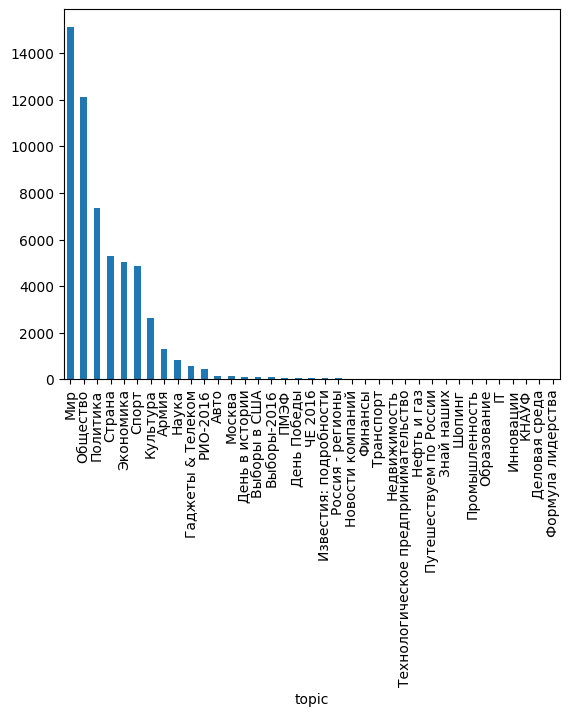

In [ ]:
# Посчитаем число текстов по темам

text_summary = df.groupby('topic').count().drop(['headline', 'Unnamed: 0', 'char_count'], axis=1)
text_summary = text_summary.sort_values(by='body', ascending=False) # Сортируем данные по убыванию.
ax = text_summary.plot.bar(y='body') # Рисуем частоты.
ax.get_legend().remove() # Удаляем легенду.

In [ ]:
print(text_summary)

                                      body
topic                                     
Мир                                  15131
Общество                             12147
Политика                              7359
Страна                                5280
Экономика                             5032
Спорт                                 4881
Культура                              2635
Армия                                 1295
Наука                                  824
Гаджеты & Телеком                      582
РИО-2016                               449
Авто                                   130
Москва                                 118
День в истории                         108
Выборы в США                            96
Выборы-2016                             92
ПМЭФ                                    63
День Победы                             62
ЧЕ 2016                                 55
Известия: подробности                   38
Россия - регионы                        26
Новости ком

Выборка несбалансирована, первые 7 классов абсолютно доминируют над оставшимися 30, более того, первые 2 класса по количеству элементов сравнимы с остальными 35. Малые классы могут вообще попасть либо только в тренировочную, либо только в тестовую выборку. Соотношение самого частого и самого редкого класса составляет 7 565,5 к 1. Ряд классов имеют похожую тематику (например Экономика близка к Промышленности и Финансам, а IT близок к Гаджеты & Телеком).

Если малые классы незначительны и вы не хотите усложнять модель, удалите их.

Если малые классы важны, но их слишком мало, рассмотрите объединение или пересэмплирование.

Если вы хотите сохранить данные и учесть их при обучении, рассмотрите взвешенные потери или oversampling.

В нашем случае проводить классификацию классов с 2, 4 или 6 элементами бессмысленно так как модель может вообще не встретить такие классы в обучающей или тестовой выборке. Большую часть самых редких классов можно отнести к более крупным, при этом если присоединить все классы, связанные с экономикой, у которых число элементов менее 26, к классу Экономика, то число элементов класса Экономика вырастет примерно на 40 записей, что составляет 0,0079 от 5032. Поэтому удалим все классы с числом записей менее хотя бы 26. При этом общее число элементов снизится крайне незначительно, примерно на 0,17%.

Число уникальных тем: 21


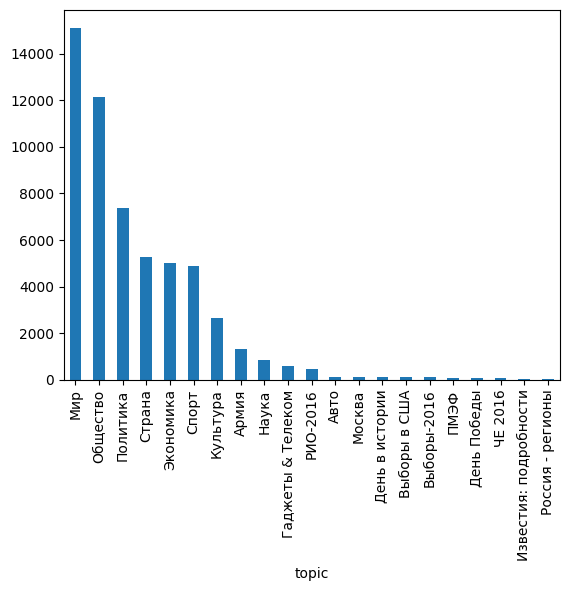

In [ ]:
# Подсчитываем количество записей для каждой темы
topic_counts = df['topic'].value_counts()

# Оставляем только темы с числом записей >= 26
topics_to_keep = topic_counts[topic_counts >= 26].index

# Фильтруем DataFrame
df = df[df['topic'].isin(topics_to_keep)]

# посчитаем количество уникальных тем
unique_topics = df['topic'].unique()
print (f'Число уникальных тем: {len(unique_topics)}')

text_summary = df.groupby('topic').count().drop(['headline', 'Unnamed: 0', 'char_count'], axis=1)
text_summary = text_summary.sort_values(by='body', ascending=False) # Сортируем данные по убыванию.
ax = text_summary.plot.bar(y='body') # Рисуем частоты.
ax.get_legend().remove() # Удаляем легенду.

В нашей выборке остались и очень крупные, и очень маленькие классы, но теперь хотя бы есть шанс что они попадут и в тренировочную, и в тестовую выборку. Также значитально уменьшилось число классов с похожими темами, хотя Выборы в США и Выборы-2016, а также Россия - регионы и Москва остались.

Делим данные на тренировочные и тестовые.

In [ ]:
X = df['body']
y = df['topic']

In [ ]:
X.shape, y.shape

((56403,), (56403,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39482,), (16921,), (39482,), (16921,))

## **Логистическая регрессия**

Начнем с самого простого и очевидного алгоритма - логистической регрессии с Bag of Words.

**Плюсы:**
- Простота реализации и интерпретации.
- Хорошо работает на небольших наборах данных.
- Быстрое обучение и предсказание.

**Минусы:**
- Не учитывает порядок слов и их контекст.
- В BoW большие тексты могут приводить к очень разреженным матрицам.
- Ограниченные возможности для обработки сложных языковых конструкций.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *
from nltk import ngrams

In [ ]:
vec = CountVectorizer(ngram_range=(1, 1)) # строим BoW для слов
bow = vec.fit_transform(X_train)

In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [ ]:
pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

                 Авто       0.42      0.64      0.51        22
                Армия       0.65      0.73      0.69       358
         Выборы в США       0.24      0.67      0.36        12
          Выборы-2016       0.22      0.46      0.30        13
    Гаджеты & Телеком       0.63      0.62      0.63       168
          День Победы       0.35      0.60      0.44        10
       День в истории       0.29      0.80      0.43        15
Известия: подробности       0.00      0.00      0.00         1
             Культура       0.84      0.87      0.85       774
                  Мир       0.80      0.76      0.78      4763
               Москва       0.00      0.00      0.00         2
                Наука       0.59      0.70      0.64       211
             Общество       0.74      0.71      0.73      3769
                 ПМЭФ       0.44      0.62      0.52        13
             Политика       0.54      0.55      0.54  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Random Forest**

**Плюсы:**
- Случайный лес устойчив к переобучению и может справляться с высокоразмерными данными (например, текстами).
- Хорошо работает с разреженными матрицами (TF-IDF).
- Может находить нелинейные зависимости между данными.

**Минусы:**
- Более медленный в обучении по сравнению с логистической регрессией.
- Может быть сложен в интерпретации.
- Требует большого объема памяти для работы с большими наборами данных.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Векторизация текста
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Обучение классификатора
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = clf.predict(X_test_tfidf)

# Вывод отчета о классификации
report = classification_report(y_test, y_pred)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

                 Авто       0.00      0.00      0.00        33
                Армия       0.94      0.39      0.56       406
         Выборы в США       0.00      0.00      0.00        33
          Выборы-2016       0.00      0.00      0.00        27
    Гаджеты & Телеком       1.00      0.05      0.09       166
          День Победы       0.00      0.00      0.00        17
       День в истории       0.00      0.00      0.00        41
Известия: подробности       0.00      0.00      0.00         5
             Культура       0.88      0.76      0.81       804
                  Мир       0.68      0.91      0.78      4527
               Москва       0.00      0.00      0.00        49
                Наука       0.85      0.28      0.43       250
             Общество       0.67      0.78      0.72      3631
                 ПМЭФ       1.00      0.11      0.20        18
             Политика       0.66      0.42      0.51  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **BERT.**

Используем трансформер RuBERT-tiny2

Плюсы данного метода:
 - Учитывает контекст и зависимости между словами при предсказывании, что позволяет ему понять семантическую связь между словами в предложении.
 - Может быть дообучен на различных задачах классификации, и его представления могут быть использованы для различных языков и типов данных.
 - Показывает высокую производительность во многих классификационных задачах, особенно на больших и сложных датасетах. Его способность учитывать контекст и семантику позволяет ему лучше идентифицировать семантическую связь между словами и принимать более точные решения о классификации.

Минусы:
 - Модель, несмотря на свою «облегченную» версию, все равно требует больше ресурсов для обучения и инференса по сравнению с классическими моделями.
 - Для достижения высокой производительности модели необходимо достаточное количество тренировочных данных.
 - Необходимо правильно подбирать гиперпараметры (например, learning rate, количество эпох) для получения оптимальных результатов.

In [ ]:
! pip install -U transformers

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=37)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
X = df['body'].values
y = df['topic'].values
labels = np.unique(y)

In [ ]:
encoded_inputs_train = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=96)
encoded_inputs_test = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=96)

In [ ]:
input_ids_train = torch.tensor(encoded_inputs_train['input_ids'])
attention_mask_train = torch.tensor(encoded_inputs_train['attention_mask'])
input_ids_test = torch.tensor(encoded_inputs_test['input_ids'])
attention_mask_test = torch.tensor(encoded_inputs_test['attention_mask'])
labels_train = torch.tensor([labels.tolist().index(label) for label in y_train])
labels_test = torch.tensor([labels.tolist().index(label) for label in y_test])

In [ ]:
# Создание датасетов
train_dataset = torch.utils.data.TensorDataset(input_ids_train, attention_mask_train, labels_train)
test_dataset = torch.utils.data.TensorDataset(input_ids_test, attention_mask_test, labels_test)

# Создание загрузчиков данных
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} loss: {total_loss/len(train_loader)}")

Epoch 1 loss: 1.1439306537622234
Epoch 2 loss: 0.6826569672939602
Epoch 3 loss: 0.5722419952202401
Epoch 4 loss: 0.4886608528829145
Epoch 5 loss: 0.40895556464694693


In [ ]:
model.eval()
predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        all_labels.extend(labels.tolist())

In [ ]:
target_names = np.unique(y_test)
print(classification_report(all_labels, predictions, target_names=target_names))

                       precision    recall  f1-score   support

                 Авто       0.50      0.55      0.52        33
                Армия       0.59      0.76      0.66       406
         Выборы в США       0.50      0.03      0.06        33
          Выборы-2016       0.75      0.22      0.34        27
    Гаджеты & Телеком       0.54      0.71      0.61       166
          День Победы       0.40      0.35      0.38        17
       День в истории       1.00      0.05      0.09        41
Известия: подробности       0.00      0.00      0.00         5
             Культура       0.76      0.91      0.83       804
                  Мир       0.81      0.83      0.82      4527
               Москва       0.00      0.00      0.00        49
                Наука       0.61      0.73      0.66       250
             Общество       0.76      0.72      0.74      3631
                 ПМЭФ       0.00      0.00      0.00        18
             Политика       0.71      0.47      0.57  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **CNN**

**Плюсы:**
- CNN хорошо захватывают локальные паттерны в тексте (например, соседние слова), что полезно для сложных текстовых структур.
- RuBERT-tiny2 предоставляет качественные контекстуальные эмбеддинги для русского языка.
- Хорошо справляется с задачами, где контекст и последовательность слов важны.

**Минусы:**
- Требует большего объема данных для эффективного обучения по сравнению с классическими алгоритмами.
- Более сложен в настройке и требует больше вычислительных ресурсов.
- Модель может быть сложной для интерпретации.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [ ]:
X = df['body']
y = df['topic']

# Кодируем метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [ ]:
# После разбиения на обучающую и тестовую выборки сбросим индексы
X_train = pd.DataFrame(X_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

In [ ]:
print(X_train.iloc[0]['body'])
print(y_train.loc[0])

владимир путин отмечать важность контроль сторона предприниматель качество исполнение принимать нормативный акт фото пресс-служба президент россия президент владимир путин проводить заседание наблюдательный совет агентство стратегический инициатива ход обсуждаться проект организация способствовать развитие экономика россия поддержка предприниматель формирование профессиональный кадры повышение престиж рабочий профессия линия ася реализовываться проект предлагать ряд интересный идея системный проект смочь объединять вокруг деловой круг эксперт представитель гражданский общество орган власть поработать достаточно эффективно новый институт развитие налаживать нормальный отношение должный отмечать широкий сотрудничество помогать добиваться практический результат интерес весь экономика страна ваш активный участие целое выполнять дорожный карта национальный предпринимательский инициатива серьезно изменяться законодательный нормативный база объективный механизм оценка правоприменение место су

In [ ]:
# Инициализация токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model_name = "cointegrated/rubert-tiny2"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Подготовка данных для модели
max_length = 2048 # ограничение модели rubert-tiny2
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]['body']
        label = self.labels.iloc[idx]
        encoding = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
        return {**encoding, 'labels': torch.tensor(label)}

In [ ]:
train_dataset = NewsDataset(X_train, y_train)
test_dataset = NewsDataset(X_test, y_test)

# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Определение модели с 3 сверточными слоями
class TextCNN(nn.Module):
    def __init__(self, num_classes):
        super(TextCNN, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.conv1 = nn.Conv1d(312, 128, kernel_size=3)  # Первый сверточный слой, 312 - длина эмбеддинга rubert tiny2
        self.conv2 = nn.Conv1d(128, 128, kernel_size=3)  # Второй сверточный слой
        self.conv3 = nn.Conv1d(128, 128, kernel_size=3)  # Третий сверточный слой
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(128 * (max_length - 6) // 2, num_classes)  # Учитываем три свертки и пуллинг

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state.permute(0, 2, 1)  # [batch_size, seq_len, hidden_size] -> [batch_size, hidden_size, seq_len]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc1(x)

In [ ]:
# Инициализация модели
model = TextCNN(num_classes=len(label_encoder.classes_))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Обучение модели
model.train()
for epoch in range(8):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}')

Epoch 1: 100%|██████████| 2468/2468 [13:12<00:00,  3.12it/s]


Epoch 1, Loss: 1.0406


Epoch 2: 100%|██████████| 2468/2468 [13:12<00:00,  3.11it/s]


Epoch 2, Loss: 0.8737


Epoch 3: 100%|██████████| 2468/2468 [13:12<00:00,  3.11it/s]


Epoch 3, Loss: 0.8286


Epoch 4: 100%|██████████| 2468/2468 [13:10<00:00,  3.12it/s]


Epoch 4, Loss: 0.7966


Epoch 5: 100%|██████████| 2468/2468 [13:09<00:00,  3.13it/s]


Epoch 5, Loss: 0.7692


Epoch 6: 100%|██████████| 2468/2468 [13:11<00:00,  3.12it/s]


Epoch 6, Loss: 0.7440


Epoch 7: 100%|██████████| 2468/2468 [13:11<00:00,  3.12it/s]


Epoch 7, Loss: 0.7198


Epoch 8: 100%|██████████| 2468/2468 [13:09<00:00,  3.13it/s]

Epoch 8, Loss: 0.6975


In [ ]:
# Сохранение только параметров модели (state_dict)
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/data/cnn_rubert_tiny2_model.pth')

# Сохранение всей модели
torch.save(model, '/content/drive/MyDrive/Colab_Notebooks/data/cnn_rubert_tiny2_full_model.pth')

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Оценка модели и вывод sklearn classification report
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

100%|██████████| 1058/1058 [05:00<00:00,  3.52it/s]


In [ ]:
print(set(all_preds))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20}


In [ ]:
print(set(all_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}


In [ ]:
# Вывод sklearn classification report
report = classification_report(all_labels, all_preds, labels=[str(label) for label in set(all_labels)],
                               target_names=label_encoder.classes_, zero_division=0)
print(report)

                       precision    recall  f1-score   support

                 Авто       0.52      0.33      0.41        33
                Армия       0.57      0.74      0.64       406
         Выборы в США       0.40      0.06      0.11        33
          Выборы-2016       0.26      0.19      0.22        27
    Гаджеты & Телеком       0.47      0.73      0.57       166
          День Победы       0.70      0.41      0.52        17
       День в истории       0.73      0.20      0.31        41
Известия: подробности       0.00      0.00      0.00         5
             Культура       0.82      0.85      0.84       804
                  Мир       0.77      0.71      0.74      4527
               Москва       0.00      0.00      0.00        49
                Наука       0.50      0.70      0.59       250
             Общество       0.66      0.67      0.66      3631
                 ПМЭФ       0.67      0.22      0.33        18
             Политика       0.57      0.50      0.54  

## **Zero-shot**

**Плюсы:**
- Не требует обучения на конкретных данных для каждой задачи.
- Может быть использована для классификации новых категорий, для которых нет обучающего набора данных.
- Гибкость при работе с множеством задач без необходимости в повторном обучении.

**Минусы:**
- Модели Zero-Shot обычно медленнее и требуют больше вычислительных ресурсов для инференса.
- Результаты могут быть менее точными по сравнению с моделями, специально обученными для конкретной задачи.
- Ограниченная точность на специализированных или очень сложных задачах.

In [ ]:
!pip install transformers[sentencepiece] -q

In [ ]:
import pandas as pd
from transformers import pipeline
from sklearn.metrics import classification_report
from tqdm import tqdm
import time

In [ ]:
# Убедимся, что классы уникальны
classes_verbalized = list(set(y_test))

# Инициализация модели
hypothesis_template = "Тема этой новости {}"
zeroshot_classifier = pipeline("zero-shot-classification", model="MoritzLaurer/multilingual-MiniLMv2-L6-mnli-xnli", device='cuda')

In [ ]:
# Предсказания с tqdm
predictions = []
start_time = time.time()
for text in tqdm(X_test, desc="Classifying"):
    output = zeroshot_classifier(text, classes_verbalized, hypothesis_template=hypothesis_template, multi_label=False)
    predictions.append(output['labels'][0])  # Берем первый предсказанный класс

# Вывод времени выполнения
end_time = time.time()
print(f"Затраченное время: {end_time - start_time:.2f} секунд")

Classifying: 100%|██████████| 16921/16921 [48:53<00:00,  5.77it/s]


Затраченное время: 2933.96 секунд


In [ ]:
# Генерация отчета
report = classification_report(y_test, predictions, labels=[str(label) for label in set(y_test)], target_names=classes_verbalized, zero_division=0)
print(report)

                       precision    recall  f1-score   support

             РИО-2016       0.00      0.00      0.00       138
Известия: подробности       0.00      0.00      0.00         5
                Наука       0.30      0.09      0.14       250
     Россия - регионы       0.00      0.60      0.00        10
       День в истории       0.05      0.07      0.06        41
               Страна       0.08      0.28      0.12      1560
    Гаджеты & Телеком       0.12      0.08      0.10       166
                Армия       0.24      0.13      0.16       406
               Москва       0.02      0.53      0.03        49
             Культура       0.26      0.04      0.08       804
          День Победы       0.01      0.35      0.02        17
                Спорт       0.75      0.30      0.43      1451
             Политика       0.26      0.04      0.07      2169
                  Мир       0.18      0.02      0.04      4527
                 Авто       0.03      0.42      0.06  

## **Выводы**

**Логистическая регрессия с Bag of Words:**

- Точность (accuracy): 75%
- Логистическая регрессия показала хорошие результаты для большинства классов, таких как "Мир" (80% точность), "Общество" (74% точность) и "Экономика" (74% точность). Эти классы имеют наибольшее количество данных, что способствует лучшему обучению модели.
- Однако она слабо справляется с малочисленными классами, такими как "Известия: подробности" и "Россия - регионы", где точность равна нулю. Это связано с тем, что BoW не учитывает контекст и зависимость между словами, что делает модель менее чувствительной к сложным структурам текста.
- Заключение: Логистическая регрессия с Bag of Words хорошо подходит для классов с большими объемами данных, но слабее справляется с малочисленными и редкими классами.

**Случайный лес с TF-IDF:**

- Точность (accuracy): 73%
- Случайный лес с TF-IDF показал сходные с логистической регрессией результаты для крупных классов, таких как "Мир" (68% точность) и "Общество" (67% точность).
- Однако модель хуже справляется с малочисленными классами, такими как "Авто" (0%), "Выборы в США" (0%) и "Известия: подробности" (0%).
- Важно отметить, что случайный лес имеет тенденцию быть менее интерпретируемым и чувствительным к редким классам.
- Заключение: Хотя TF-IDF помогает лучше учитывать важные слова, модель все еще плохо работает с малочисленными классами. Случайный лес хорошо подходит для задач с большим количеством признаков, но требует доработки для лучшего учета редких классов.

**BERT (RuBERT-tiny2):**

- Точность (accuracy): 77%
- Модель BERT показала более высокие результаты на крупных классах, таких как "Мир" (81% точность), "Экономика" (72% точность) и "Политика" (71% точность).
- BERT, благодаря своим контекстным эмбеддингам, лучше справляется с классификацией текстов, даже когда классы имеют малые размеры, например "Авто" (50%) и "День Победы" (40%).
- Однако модель все еще испытывает проблемы с очень редкими классами, где данных слишком мало для адекватного обучения.
- Заключение: BERT — мощная модель, особенно для задач, где требуется учитывать контекст текста. Она превосходит простые модели, но требует достаточного объема данных для эффективной работы.

**CNN:**

- Точность (accuracy): 70%
- Сверточная нейронная сеть (CNN) показала результаты ниже, чем BERT, но лучше, чем случайный лес на некоторых малочисленных классах, таких как "Авто" (52%), "Гаджеты & Телеком" (47%).
- CNN хорошо справляется с задачами, где важен порядок слов и соседние зависимости, что дает ей преимущество перед BoW и TF-IDF.
- Заключение: CNN может быть эффективной для задач, где контекст и соседние слова играют ключевую роль. Однако для задачи классификации новостей она уступает более сложным моделям, таким как BERT.

**Zero-Shot:**

- Точность (accuracy): 10%
- Модель Zero-Shot показала наихудшие результаты, с точностью 0% для большинства классов.
- Это ожидаемо, так как Zero-Shot классификация не требует обучения на тренировочных данных, но использует обобщенные знания из предобученной модели. - Она неэффективна для такой сложной и многоклассовой задачи, как классификация новостей.
- Заключение: Zero-Shot классификация плохо подходит для задачи с большим числом классов и разнородными темами. Она может быть полезна для небольших, простых задач, но явно уступает обучаемым моделям на конкретных данных.

**Выводы о применимости методов и качестве решения задачи:**

- Модели, такие как BERT и CNN, показывают лучший результат на задаче классификации новостей, благодаря способности учитывать контекст и структуру текста. Однако они требуют больше вычислительных ресурсов и времени на обучение.

- Классические методы (логистическая регрессия и случайный лес) все еще дают неплохие результаты, особенно для крупных классов. Они проще в использовании и быстрее обучаются, но менее эффективны для редких классов и сложных текстов.

- Zero-Shot подход оказался неэффективным для многоклассовой классификации новостей. Этот метод может быть полезен для небольших задач, но не подходит для крупномасштабных проектов с множеством категорий.

- Общий вывод: Для задачи классификации новостей наиболее эффективными оказываются модели, способные учитывать контекст, такие как BERT. Однако для эффективного их использования необходимо обеспечить достаточное количество данных для всех классов, либо рассмотреть возможность обработки редких классов (например, объединение или удаление).